In [144]:
import jax.numpy as np
from scipy.special import factorial
import matplotlib.pyplot as plt
from scipy.special import j1
from scipy.special import gamma
from scipy.special import loggamma

In [66]:
def c_n(n):
    prefac = (-1)**n/(2**(2*n+2))
    s = 0
    for k in range(n+1):
        s += 1/(factorial(k)*factorial(k+1)*factorial(n-k)*factorial(n-k+1))
    s *= prefac
    return s

def h_omega(freqs, diam, alpha, n_max):
    a = np.pi * diam * alpha
    prefac = np.pi**(1j * freqs) * diam**(1j * freqs + 1) * a**(1-1j*freqs)
    s = 0
    for n in range(n_max+1):
        s += c_n(n) * a**(2*n) * gamma(2*n+1) * (gamma(1-1j*freqs)/gamma(2*n + 2 - 1j*freqs) + gamma(1j*freqs - 2*n - 1)/gamma(1j*freqs))
    s *= prefac
    return s

z_max = 5
z = np.linspace(-z_max,z_max,1024)
# yeah for too high n we get NaNs but you get the point
n_max = 10
z_func = 0
for n in range(n_max+1):
    z_func += c_n(n) * z**(2*n)


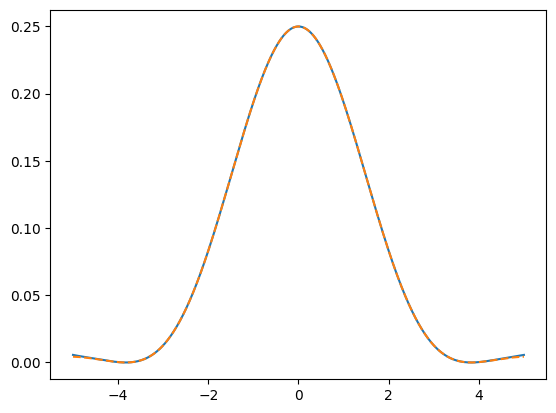

In [64]:
plt.plot(z, z_func)
plt.plot(z, j1(z)**2/z**2, linestyle='--')
plt.show()

In [122]:
f_max = 1
freqs = np.linspace(-f_max,f_max,1024)
period = 300e-6
alpha = np.sqrt(2)/period
diameter = 0.125

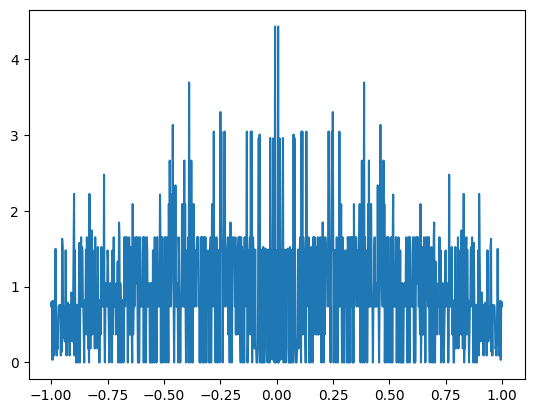

In [114]:
h_om = h_omega(freqs, diameter, alpha, 1)
plt.plot(freqs,np.abs(h_om))
plt.show()

In [285]:
import mpmath as mp
mp.dps = 50

def j_mpmath(freq, a, n_max=60):
    w = 1j*freq
    s = mp.mpc(0)
    for n in range(n_max+1):
        cn = sum(
            1/(mp.factorial(k)*mp.factorial(k+1)
              *mp.factorial(n-k)*mp.factorial(n-k+1))
            for k in range(n+1)
        ) * (-1)**n/mp.power(2,2*n+2)
        t = mp.loggamma(1 - w) - mp.loggamma(2*n +2 - w)
        u = mp.loggamma(w - 2*n - 1) - mp.loggamma(w)
        s += cn * mp.power(a,2*n) * mp.exp(mp.loggamma(2*n+1)) * (mp.exp(t) + mp.exp(u))
    return s


In [301]:
import numpy as np
f_max = 10
freqs = np.linspace(-f_max,f_max,128)
# Completely materialize as pure Python
python_freqs = [ float(f) for f in np.asarray(freqs) ]
a_scalar    = 30 #float((1*np.pi * diameter * alpha).item())

bigJ = []
bigJ_2 = []
nmax = 70
for f in python_freqs:
    bigJ.append(j_mpmath(f, a_scalar, nmax))
    bigJ_2.append(j_mpmath(f, a_scalar, int(nmax/2)))
bigJ = np.array(bigJ) 


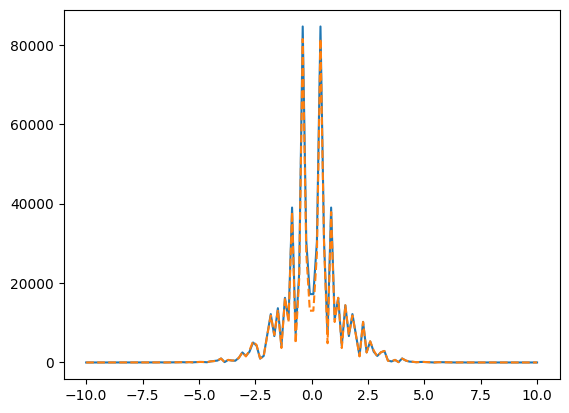

In [302]:
plt.plot(freqs, np.abs(bigJ))#/np.max(np.abs(bigJ)))
plt.plot(freqs, np.abs(bigJ_2), linestyle='--')#/np.max(np.abs(bigJ_2)), linestyle='--')
#plt.yscale('log')
plt.show()

In [303]:
from mpmath import hyper, gamma

def J_hyper(alpha, omega):
    a = mp.pi * diameter * alpha
    z = -a**2/4
    w = 1j*omega
    F1 = hyper( [1,1,1/2], [1-w/2, 3/2-w/2], z )
    F2 = hyper( [1,1,1/2], [w/2, 1/2+w/2], z )
    pref = a**(1-w)/4
    return pref* ( gamma(1-w)/(1-w)*F1 + F2/(w-1))

In [331]:
import numpy as np
f_max = 100
freqs = np.linspace(-f_max,f_max,1024)
# Completely materialize as pure Python
python_freqs = [ float(f) for f in np.asarray(freqs) ]
alpha = 1*np.sqrt(2)/period

Jhyp = []
Jnot = []
Jbad = []
for f in python_freqs:
    Jhyp.append(J_hyper(alpha, f))
    Jnot.append(J_hyper(1, f))
    Jbad.append(j_mpmath(f,mp.pi*diameter,10))


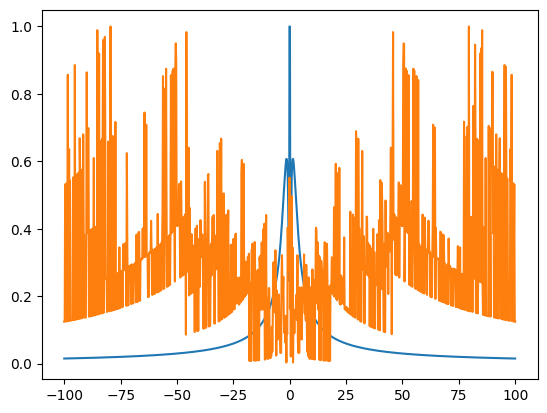

In [341]:
#plt.plot(freqs, np.abs(Jhyp))
plt.plot(freqs, np.abs(Jnot)/np.max(np.abs(Jnot)))
plt.plot(freqs, np.abs(Jbad)/np.max(np.abs(Jbad)))
plt.show()

In [342]:
from scipy.integrate import quad
def numeric_J(alpha, omega):
    def integrand_real(tau):
        x = tau - alpha

        val = 0.25 if abs(x) < 1e-8 else (j1(x)**2 / x**2)
        return val * np.cos(omega * np.log(tau))
    
    def integrand_imag(tau):
        x = tau - alpha
        val = 0.25 if abs(x) < 1e-8 else (j1(x)**2 / x**2)
        return - val*np.sin(omega * np.log(tau))
    
    real1, _ = quad(integrand_real, 0, alpha)
    real2, _ = quad(integrand_real, alpha, np.inf)
    imag1, _ = quad(integrand_imag, 0, alpha)
    imag2, _ = quad(integrand_imag, alpha, np.inf)

    return real1 + real2 + 1j*(imag1 + imag2)

In [367]:
f_max = 100
freqs = np.linspace(-f_max,f_max,1024)
# Completely materialize as pure Python
python_freqs = [ float(f) for f in np.asarray(freqs) ]
alpha = 0.1*np.sqrt(2)/period
numJ = []
Jnot = []
for f in python_freqs:
    # Jhyp.append(J_hyper(alpha, f))
    Jnot.append(J_hyper(alpha, f))
    # Jbad.append(j_mpmath(f,mp.pi*diameter,10))
    numJ.append(numeric_J(np.pi*alpha*diameter,f))

/var/folders/2s/299fsjvd5w13x4x_w7x554fh0000gn/T/ipykernel_5545/4103154134.py:14: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  real1, _ = quad(integrand_real, 0, alpha)
/var/folders/2s/299fsjvd5w13x4x_w7x554fh0000gn/T/ipykernel_5545/4103154134.py:15: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitt

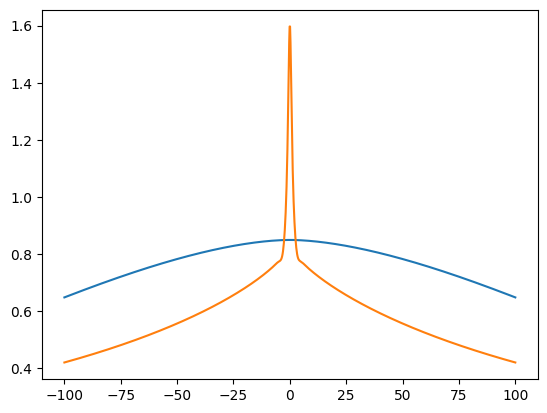

In [368]:
plt.plot(freqs, np.abs(numJ))
plt.plot(freqs, np.abs(Jnot))
#plt.xlim(-1000,1000)
plt.show()